In [1]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [2]:
DIR = '../../data/processed'
crawls = glob.glob('{}/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [3]:
df.columns

Index(['claim', 'descriptions', 'img', 'label', 'legal_page_urls', 'page_urls',
       'text_on_image', 'url_caption', 'known_urls', 'true_perc', 'false_perc',
       'mixed_perc', 'invalid_count', 'known_count', 'total_count'],
      dtype='object')

In [4]:
df = df[['legal_page_urls', 'label']][df.label!='mixture']

In [5]:
df.shape

(969, 2)

In [6]:
df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

In [7]:
df_labels = pd.read_csv('{}/known_articles_labeled.csv'.format(DIR)).set_index('url')

In [32]:
df_labels[df_labels.index.duplicated(keep=False)]

authors  \
url                                                                                                     
https://www.nytimes.com/2018/11/04/us/politics/...                                    ['Kevin Roose']   
https://www.nytimes.com/2018/10/24/world/americ...                                    ['Kevin Roose']   
https://www.nytimes.com/2018/10/24/world/americ...                                    ['Kevin Roose']   
https://www.thatsnonsense.com/10-viral-photos-f...                                  ['Craig Charles']   
https://www.nytimes.com/2018/11/04/us/politics/...                                    ['Kevin Roose']   
https://www.thatsnonsense.com/10-viral-photos-f...                                  ['Craig Charles']   
https://www.nytimes.com/2018/09/11/us/politics/...                                    ['Peter Baker']   
https://www.mediaite.com/online/watch-trump-do-...                                      ['Ken Meyer']   
https://www.nytimes.com/2018/09/11/us/politics/...                                     ['Lisa Lerer']   
https://www.thestar.com/news/world/analysis/201...  ['Https', 'Www.Facebook.Com Pages Daniel-Dale'...   
https://www.nytimes.com/2018/09/11/us/politics/...                                    ['Peter Baker']   
https://www.mediaite.com/online/watch-trump-do-...                                      ['Ken Meyer']   
https://www.nytimes.com/2018/09/11/us/politics/...                                     ['Lisa Lerer']   
https://www.thestar.com/news/world/analysis/201...  ['Https', 'Www.Facebook.Com Pages Daniel-Dale'...   
http://listverse.com/2018/11/21/10-viral-photos...                                                 []   
https://www.thatsnonsense.com/10-viral-photos-f...                                  ['Craig Charles']   
https://www.gizmodo.com.au/2016/12/7-more-viral...                  ['Tegan Jones', 'Sam Rutherford']   
https://www.gizmodo.com.au/2016/12/7-more-viral...                  ['Tegan Jones', 'Sam Rutherford']   
https://gizmodo.com/12-more-viral-images-that-a...  ['Matt Novak', 'About The Author', "Matt Novak...   
https://gizmodo.com/76-viral-images-from-2015-t...                                     ['Matt Novak']   
http://listverse.com/2018/11/21/10-viral-photos...                                                 []   
https://gizmodo.com/12-more-viral-images-that-a...  ['Matt Novak', 'About The Author', "Matt Novak...   
https://www.gizmodo.com.au/2016/12/69-viral-ima...                  ['Tegan Jones', 'Sam Rutherford']   
https://www.gizmodo.com.au/2016/01/9-more-viral...                  ['Tegan Jones', 'Sam Rutherford']   
https://www.gizmodo.com.au/2016/12/69-viral-ima...                  ['Tegan Jones', 'Sam Rutherford']   
https://www.buzzfeed.com/whitneyjefferson/anima...                                 ['Buzzfeed Staff']   
https://gizmodo.com/76-viral-images-from-2015-t...                                     ['Matt Novak']   
https://www.gizmodo.com.au/2016/12/69-viral-ima...                  ['Tegan Jones', 'Sam Rutherford']   
https://www.gizmodo.com.au/2016/01/9-more-viral...                  ['Tegan Jones', 'Sam Rutherford']   
https://www.gizmodo.com.au/2016/12/69-viral-ima...                  ['Tegan Jones', 'Sam Rutherford']   
https://www.gizmodo.com.au/2016/01/9-more-viral...                  ['Tegan Jones', 'Sam Rutherford']   
https://gizmodo.com/76-viral-images-from-2015-t...                                     ['Matt Novak']   
https://www.buzzfeed.com/jessicamisener/the-29-...                                 ['Buzzfeed Staff']   
https://gizmodo.com/76-viral-images-from-2015-t...                                     ['Matt Novak']   
https://gizmodo.com/76-viral-images-from-2015-t...                                     ['Matt Novak']   
https://www.buzzfeed.com/whitneyjefferson/anima...                                 ['Buzzfeed Staff']   
https://www.dailydot.com/culture/pinterest-hoax...  ['Gavia Baker-Whitelaw', 'Lauren Rae Orsini Is...   

In [40]:
df_labels.loc['https://www.glamour.com/story/photo-alexandria-ocasio-cortez-new-congresswomen-squad-goals']['media_label']

'TRUE'

In [43]:
df_labels = df_labels[~df_labels.index.duplicated(keep='first')]

In [45]:
def get_title(url):
    if url in df_labels.index and df_labels.loc[url]['media_label'] == 'TRUE':
        return str(df_labels.loc[url].title)
    return ''

In [46]:
df['media_titles'] = df.legal_page_urls.map(lambda x: ' '.join([get_title(y) for y in x]).strip())

In [47]:
df = df.replace('',np.nan).dropna()

In [48]:
df.media_titles.iloc[0]

"Photo of Newly Elected Congresswomen Alexandria Ocasio-Cortez, Rashida Tlaib, Ilhan Omar, and Ayanna Pressley New Congresswoman Rashida Tlaib not apologizing for cursing out Trump in call for impeachment      The sisterhood of congressional 'firsts': Diverse group of newly elected women bond over common status and goals     The power of this Instagram goes way beyond gender or race      Ocasio-Cortez shares photo of new ‘squad’ on Capitol Hill    The 116th Congress Has More Women Than Ever Before     The new Democrats in DC The revolutionary strategy hidden in U.S. Rep.-elect Alexandria Ocasio-Cortez’s Instagram feed Midterms News, Tips & Guides Midterm Elections News, Tips & Guides   New York’s Legislature Must Appoint a Woman Attorney General      After historic election, Rashida Tlaib sets sights on elevating her district’s voice in Congress"

In [49]:
df.label.value_counts(normalize=True)

false    0.64751
true     0.35249
Name: label, dtype: float64

In [50]:
X = list(df.media_titles)
y = df.label.apply(lambda x: True if x=='true' else False).ravel()

In [80]:
len(X)

261

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [52]:
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

In [64]:
sm = SMOTE(ratio = 'auto', k_neighbors = 5, n_jobs = -1)
#smote_enn = SMOTEENN(smote = sm)

clf = SVC()
# SVC
parameters = {
    #'smote_enn__smote__k_neighbors': [1,2,3,4,5,10],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'], 
              'clf__C': [0.001, 0.01, 0.1, 0.25,0.5,0.75, 1,10, 25, 50, 100, 1000],
              'clf__gamma': [0.0001,0.001,0.01,0.1,1,2,3,'auto','scale'],
             'clf__class_weight': ['balanced'],
             'clf__probability': [True]}

steps = [('vectorizer', CountVectorizer(stop_words='english')), 
         ('scaler', MaxAbsScaler()),
         #('smote_enn', smote_enn), 
         ('clf', clf)]

pipeline = Pipeline(steps)

rs_clf = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=100, verbose=2,

                            scoring='f1', refit=True,cv=folds, random_state=42, n_jobs=-1)

In [65]:
rs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    8.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.7s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
  ...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'clf__kernel': ['linear', 'rbf', 'sigmoid'], 'clf__C': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 25, 50, 100, 1000], 'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 'auto', 'scale'], 'clf__class_weight': ['balanced'], 'clf__probability': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          retur

In [66]:
best_score = rs_clf.best_score_

best_params = rs_clf.best_params_

print("Best score: {}".format(best_score))

print("Best params: {}".format(best_params))

Best score: 0.5404676565966887
Best params: {'clf__probability': True, 'clf__kernel': 'sigmoid', 'clf__gamma': 3, 'clf__class_weight': 'balanced', 'clf__C': 0.25}


In [67]:
pd.Series(y_test).value_counts(normalize=True)

False    0.651515
True     0.348485
dtype: float64

In [68]:
pred = rs_clf.predict(X_test)
pd.Series(pred).value_counts(normalize=True)

True     0.560606
False    0.439394
dtype: float64

In [69]:
y_pred = rs_clf.predict_proba(X_test)
y_pred = y_pred[:,1]

In [70]:
y_pred

array([0.40003652, 0.37739129, 0.45835322, 0.35089746, 0.517101  ,
       0.41703524, 0.19292674, 0.43308278, 0.33085919, 0.36075577,
       0.41015799, 0.40741454, 0.33119056, 0.21640231, 0.38096639,
       0.37878282, 0.23683596, 0.32287044, 0.34721583, 0.29795695,
       0.23409117, 0.32263096, 0.16240184, 0.33008726, 0.26299013,
       0.34721583, 0.4136656 , 0.36428086, 0.32184675, 0.3602469 ,
       0.30798081, 0.36645715, 0.4326684 , 0.43913447, 0.30959077,
       0.36273713, 0.32060534, 0.31111112, 0.5       , 0.25997521,
       0.36654958, 0.41987866, 0.28749414, 0.26764051, 0.33275863,
       0.34721583, 0.5       , 0.36885829, 0.36592173, 0.30959078,
       0.36222464, 0.36222464, 0.474831  , 0.46087987, 0.29277618,
       0.26584707, 0.45111452, 0.28186233, 0.35362218, 0.40218107,
       0.43913447, 0.39397082, 0.35713964, 0.45617005, 0.42981447,
       0.29142488])

In [71]:
roc_auc_score(y_test, y_pred)

0.6496461071789686

In [78]:
pred_all_true = np.array([True] * len(pred))

In [79]:
f1_score(y_test, pred_all_true)

0.5168539325842696

In [74]:
f1_score(y_test, pred)

0.5333333333333333

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.46')

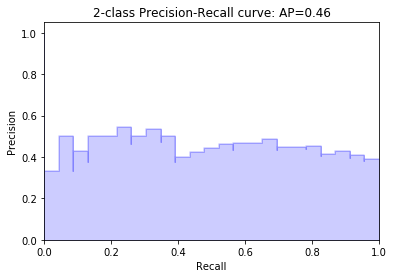

In [75]:
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))